# # This notebook reproduces the analysis used to produce Figure 2, which incorporates the equations discussed in Section 2.1 of Maryann et al. 2025 for asteroid 4953/1990 MU's distance measurement. All steps, parameters, and fits match the methodology described in Section 2.2 of the manuscript.

# Step 1: Here we import all the packages used throughout the notebook:

In [23]:
# For numerical arrays and dataframes.
import numpy as np
import pandas as pd

# For handling plotting and axis formatting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# For custom subplot layouts
from matplotlib.gridspec import GridSpec

# Tools for fitting functions to data
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit

# For file handling and regular expressions
import re
import os
from pathlib import Path

# Access to trigonometric functions and constants.
import math

# # Step 2: Reading and Extracting the raw data of asteroid 4953/1990 MU from the NASA JPL Horizon System

In [24]:
# Here, we specify the text file downloaded from Horizons, which is mentioned in GitHub folder 1 as 'Figure 1 (4953).txt', containing only the selected columns. 
# Date__(UT)__HR:MN = the time frame of the 48 observations from October 30-31, 2024, separated by 1 hour, totaling 48 observations. 
# R.A._(ICRF), DEC__(ICRF) = The RA and DEC data of each observation in decimal format
# delta = the distance to the asteroid at each observation in astronomical units (au). We will use this only to verify our distance measurement in steps 14 and 15. 
# deldot = the range rate (km/sec). A positive deldot indicates the object is moving away from the observer, and a negative deldot indicates the object is moving towards.

# Here, we define a list containing the Horizons text.

txt_files = ['Figure 2 (4953).txt']

# In the list, the following are column headers in the DataFrame. The blanks denoted by '' correspond to columns that are not required in the analysis. 
# A pandas.DataFrame is created using the specified column names.
columns = ['Date__(UT)__HR:MN', '', '', ' R.A._(ICRF)', 'DEC__(ICRF)', 'delta', '     deldot', '']

# We convert the document from a .txt file to a .csv file. 
# This loop could process multiple .txt files, but in this analysis it iterates over a single file.
for file_path in txt_files:

    # We only want to extract the code between “SOE” (Start of Ephemeris) and “EOE” (End of Ephemeris), since they contain the ephemeris data. 
    start_marker = "$$SOE"
    end_marker = "$$EOE"

    # open: opens the file in read mode ('r'). The with statement ensures that the file is closed properly after it is read.
    with open(file_path, 'r') as file:

        # data_lines collects the data row by row between SOE and EOE.
        # is_data is a Boolean flag. It indicates if an ephemeris row of data is within the appropriate data section row.
        data_lines = []
        is_data = False 

        # Iterates through every line 
        for line in file:
            
            # When a row of lines contains SOE, the start marker, the is_data is set to True. Beyond this line, data will be captured.
            if start_marker in line:
                is_data = True
            # When a row of lines contains EOE, the end marker, the is_data is set to False. Beyond this line, data will not be captured.
            elif end_marker in line:
                is_data = False
            # In the case if neither marker is found, and is_data is true, this means that data capturing is still on-going, and hasn't reached EOE. 
            elif is_data:
                # .strip() removes whitespace and appends lines to data_lines.
                data_lines.append(line.strip())
    
   # Each line of ephemeris data that is captured is split at the commas to form string values that are in the form of rows and columns (lists of lists) for the .csv. 
    data = [line.split(",") for line in data_lines]
    
    # max_columns searches for the longest row and its length.
    max_columns = max(len(row) for row in data)

    # Shorter rows are padded with empty strings at locations that do not have data, to represent the same length as the longest row. 
    # This is to make sure that the DataFrame is being created without misaligned columns.
    data = [row + [''] * (max_columns - len(row)) for row in data]

    # Convert the rows and columns data into a pandas.DataFrame, assigning the predefined column names from columns. 
    # The DataFrame is the in‑memory representation of your table.
    df = pd.DataFrame(data, columns=columns)

    # os.path.basename(file_path) extracts the filename
    # os.path.splitext(...)[0] removes the file extension (.txt)
    base_name = os.path.splitext(os.path.basename(file_path))[0]

    # A new .csv is appended to the newly created file
    csv_file_path = f'{base_name}.csv'

    # The DataFrame is exported to a .csv file. Passing index=False prevents the DataFrame’s index from being written as an extra column.
    df.to_csv(csv_file_path, index=False)
    print(f"CSV file saved: {csv_file_path}")
    

CSV file saved: Figure 2 (4953).csv


# Step 3: Reading of the newly created .csv file. 

In [25]:
# Here, we read and print the newly created .csv file to verify if the data is correctly extracted and formatted. 
file_path1 = 'Figure 2 (4953).csv'
data1 = pd.read_csv(file_path1)
print(data1.to_string(index=False))

 Date__(UT)__HR:MN Unnamed: 1 Unnamed: 2   R.A._(ICRF)  DEC__(ICRF)    delta       deldot  Unnamed: 7
      2.460614e+06          A                11.417412   -36.811213 1.146946    -0.504864         NaN
      2.460614e+06                           11.394452   -36.808871 1.146934    -0.424518         NaN
      2.460614e+06                           11.371428   -36.806443 1.146925    -0.333521         NaN
      2.460614e+06                           11.348379   -36.803920 1.146918    -0.237308         NaN
      2.460614e+06                           11.325346   -36.801301 1.146914    -0.141674         NaN
      2.460614e+06                           11.302369   -36.798590 1.146911    -0.052373         NaN
      2.460614e+06                           11.279488   -36.795793 1.146911     0.025274         NaN
      2.460614e+06                           11.256733   -36.792924 1.146913     0.086743         NaN
      2.460614e+06                           11.234131   -36.789998 1.146915     0

# Step 4: Addition of a randomly generated 20 milliarcseconds (mas) noise to each observation in the RA and DEC. 

In [26]:
# input_file: The original file path with RA and DEC of zero error.
# output_file: The new file path with added noise. 
input_file  = Path("Figure 2 (4953).csv")
output_file = Path("Figure 2 (4953)_20mas.csv")

# The columns that need noise addition. 
RA_COL  = " R.A._(ICRF)"      
DEC_COL = "DEC__(ICRF)"

# # Horizons does not provide measurement uncertainties in RA and DEC. So, we randomly add 20 mas of noise to mimic real astrometric errors.
# 20 mas converted to arcseconds. 1 mas = 0.001 arcsec and 20 mas = 0.020 arcsec
# The noise is Gaussian-distributed, consistent with typical astrometric uncertainties.
# 20 mas was chosen since it is as a realistic uncertainty approximation based on typical CCD astrometric performance.
SIGMA_ARCSEC = 0.020        

# converting arcseconds into degrees because RA/DEC in the downloaded original Horizons file is in degrees (1 degree = 3600"). 
SIGMA_DEG    = SIGMA_ARCSEC / 3600.0  

# A random generator. seed=42 ensures reproducible noise, where every run of the code ensures that the noise to the observations stays the same. 
rng = np.random.default_rng(seed=42)

# Reads the CSV into a DataFrame, where each row is an observation.
df = pd.read_csv(input_file)

# A safety check: If RA or DEC columns are missing, stop the code and show an error.
if RA_COL not in df.columns or DEC_COL not in df.columns:
    raise ValueError("RA/DEC columns not found in file")

# Extract the RA and DEC columns into a NumPy array.
ra  = df[RA_COL].to_numpy(dtype=float)
dec = df[DEC_COL].to_numpy(dtype=float)

# Generate one random noise value per RA and DEC observation where Mean = 0, Standard deviation = 20 mas in degrees, Size = number of observations (48)
ra_noise  = rng.normal(0.0, SIGMA_DEG, size=len(df))
dec_noise = rng.normal(0.0, SIGMA_DEG, size=len(df))

# Adds noise to each RA. % 360.0: wraps RA so that values remain within 0–360 degrees. 
ra_new  = (ra + ra_noise) % 360.0
# Adds noise to each DEC. Limits the DEC at -90 and +90, since it cannot exceed the poles. 
dec_new = np.clip(dec + dec_noise, -90.0, 90.0)

# Printing a readable header to see the comparison. 
print(f"\n=== {input_file.name} ===")
print("Obs |     Original_RA     Original_DEC |    RA_noise(deg)   DEC_noise(deg) |   RA_noise(mas)   DEC_noise(mas) |          New_RA          New_DEC")
print("----+------------------+----------------+----------------------------------+----------------------------------+---------------------------------")
for i in range(len(df)):
    print(f"{i+1:3d} | "
          f"{ra[i]:16.9f} {dec[i]:15.9f} | "
          f"{ra_noise[i]:16.9f} {dec_noise[i]:16.9} | "
          f"{ra_noise[i]*3600*1000:16.9} {dec_noise[i]*3600*1000:15.9} | "
          f"{ra_new[i]:16.13} {dec_new[i]:16.13}")

# In the newly created .csv file with the noise, the original Horizons file is now replaced with noise in RA and DEC. 
df[RA_COL]  = ra_new
df[DEC_COL] = dec_new
df.to_csv(output_file, index=False)
print(f" Saved {output_file}")


=== Figure 2 (4953).csv ===
Obs |     Original_RA     Original_DEC |    RA_noise(deg)   DEC_noise(deg) |   RA_noise(mas)   DEC_noise(mas) |          New_RA          New_DEC
----+------------------+----------------+----------------------------------+----------------------------------+---------------------------------
  1 |     11.417411883   -36.811212742 |      0.000001693   3.77174202e-06 |        6.0943416      13.5782713 |   11.41741357587  -36.81120897026
  2 |     11.394452070   -36.808871159 |     -0.000005778   3.75439275e-07 |      -20.7996821      1.35158139 |   11.39444629231  -36.80887078356
  3 |     11.371428148   -36.806442656 |      0.000004169   1.60621888e-06 |       15.0090239      5.78238797 |   11.37143231717  -36.80644104978
  4 |     11.348378870   -36.803920085 |      0.000005225   3.50715681e-06 |       18.8112943      12.6257645 |   11.34838409536  -36.80391657784
  5 |     11.325345542   -36.801301356 |     -0.000010839  -8.09531011e-06 |      -39.0207038    

# Step 5: Reading of the newly created .csv file with noise. 

In [27]:
# We print the noise-filled RA and DEC to verify if the data is correctly extracted and formatted. 
file_path = 'Figure 2 (4953)_20mas.csv'
data = pd.read_csv(file_path)
print(data.to_string(index=False))

 Date__(UT)__HR:MN Unnamed: 1 Unnamed: 2   R.A._(ICRF)  DEC__(ICRF)    delta       deldot  Unnamed: 7
      2.460614e+06          A                11.417414   -36.811209 1.146946    -0.504864         NaN
      2.460614e+06                           11.394446   -36.808871 1.146934    -0.424518         NaN
      2.460614e+06                           11.371432   -36.806441 1.146925    -0.333521         NaN
      2.460614e+06                           11.348384   -36.803917 1.146918    -0.237308         NaN
      2.460614e+06                           11.325335   -36.801309 1.146914    -0.141674         NaN
      2.460614e+06                           11.302362   -36.798591 1.146911    -0.052373         NaN
      2.460614e+06                           11.279488   -36.795795 1.146911     0.025274         NaN
      2.460614e+06                           11.256732   -36.792927 1.146913     0.086743         NaN
      2.460614e+06                           11.234130   -36.790000 1.146915     0

# Step 6: Printing the time and RA needed for the topocentric parallax analysis. 

In [28]:
# Subtracting the minimum in the time column to make the first observation start at 0
# By shifting the first observation to x = 0, we improve numerical stability in nonlinear least-squares fitting
jd_adjusted = data['Date__(UT)__HR:MN']
jd_binned_median = jd_adjusted - jd_adjusted.min()

# Extracting the RA values
ra_deg_adjusted_detected = data[' R.A._(ICRF)']

print(f"{'JD Adjusted':<25}{'RA Adjusted Detected':<25}")
print("=" * 75)

for jd, ra in zip(jd_binned_median, ra_deg_adjusted_detected):
    print(f"{jd:<25.10f}{ra:<25.10f}")

JD Adjusted              RA Adjusted Detected     
0.0000000000             11.4174135759            
0.0416666670             11.3944462923            
0.0833333330             11.3714323172            
0.1250000000             11.3483840954            
0.1666666670             11.3253347029            
0.2083333330             11.3023619547            
0.2500000000             11.2794884512            
0.2916666670             11.2567316641            
0.3333333330             11.2341304507            
0.3750000000             11.2116891009            
0.4166666670             11.1894323415            
0.4583333330             11.1673289921            
0.5000000000             11.1453687298            
0.5416666670             11.1235384555            
0.5833333330             11.1017850163            
0.6250000000             11.0800754422            
0.6666666670             11.0583864006            
0.7083333330             11.0366486909            
0.7500000000             11.014

# Step 7: Equation 5 in Maryann et al. 2025

In [29]:
# Equation 5 in the paper. We use the quadratic function since the observations for 4953/1990 MU in this analysis exceed a single night. 
# Am * np.sin(2 * np.pi * x + B) is the Earth's rotation (x = time, Am = amplitude of the signal, B = phase shift). 
# C * x + D + E * x**2 is the asteroids non-linear motion (Cx = asteroids linear motion shows a constant angular velocity, D = RA offset, E x^2 = asteroids non-linear motion is due to changing geometry and orbital acceleration)
# fit_function_linear defines a Python function

def fit_function_linear(x, A, B, C, D, E):
    return A * np.sin(2 * np.pi * x + B) + C * x + D + E * x**2

# curve_fit() from scipy.optimize performs a nonlinear least-squares fit. It finds the best fit values for A, B, C, D, E that fit the RA data with the 20 mas noise as seen in the above defined function. 
# params_sine = a NumPy array of best-fit parameter values
# covariance_sine = 5×5 covariance matrix describing the uncertainties and correlations for A, B, C, D, E.

params_sine, covariance_sine = curve_fit(fit_function_linear, jd_binned_median, ra_deg_adjusted_detected)
print(f"\033[1;32m Equation 5: sine +linear terms (Paramters):     {params_sine}\033[0m")

# Uncertainties in Equation 5. It is important for understanding of error propagation. 
# np.diag(covariance_sine) extracts diagonal elements, the variances of A, B, C, D, E.
# np.sqrt(...) takes the square root, giving the standard deviations (1σ uncertainties).

sine_uncertainties = np.sqrt(np.diag(covariance_sine))
print(f"\033[1;32m Equation 5: sine +linear terms (Uncertainities):{sine_uncertainties}\033[0m")

 Equation 5: sine +linear terms (Paramters):     [ 2.30565316e-03  2.40731197e+00 -5.39828774e-01  1.14159013e+01
  3.75520750e-03]
 Equation 5: sine +linear terms (Uncertainities):[2.65400127e-06 1.16088377e-03 1.25150031e-05 5.36396043e-06
 6.15729676e-06]


# Step 8: The parallax amplitude and uncertainty from the asteroids non-linear sinusoidal signal

In [30]:
# We read only the parallax amplitude and its uncertainty, and convert to radians. 
# A closer asteroid → larger sinusoidal amplitude; A farther asteroid → smaller amplitude

amplitude_deg = params_sine[0]
amplitude_rad = math.radians(amplitude_deg)
print(f"\033[1;32mamplitude (rad):              {amplitude_rad}\033[0m")
 
amplitude_uncertainty_deg = sine_uncertainties[0]
amplitude_uncertainty_rad = math.radians(amplitude_uncertainty_deg)
print(f"\033[1;32mamplitude uncertianity (rad): {amplitude_uncertainty_rad}\033[0m")

amplitude (rad):              4.0241239012408515e-05
amplitude uncertianity (rad): 4.632106058982249e-08


# Step 9: Equation 4 in Maryann et al. 2025 (Distance measurement with respect to the center of the Earth)

In [31]:
earth_radius_km = 6371  # in km

# Distance measurement concerning the center of the Earth. 
distance_km = earth_radius_km / amplitude_rad

# Compute distance uncertainty
distance_uncertainty_km = (earth_radius_km/amplitude_rad) * (amplitude_uncertainty_rad/abs(amplitude_rad))

print(f"\033[1;32mEquation 3: Distance_km: {abs(distance_km):.2f} ± {abs(distance_uncertainty_km):.2f}\033[0m")

Equation 3: Distance_km: 158320174.93 ± 182239.88


# Step 10: Latitude of the Observatory (Correction 1)

In [32]:
# The observatory taking the observations of asteroid 4953/1990 MU is the Cerro Tololo Observatory, La Serena, (code: 807) 
# The observatory is situated at an altitude of 2200 m
# The observatory is in the southern hemisphere of the Earth at a latitude of 30.1732° S. 
# We convert the latitude in degrees to radians. 

latitude_deg = 30.1732 
latitude_rad = math.radians(latitude_deg)
print("Latitude (rad):              ", latitude_rad)

Latitude (rad):               0.526621685862753


# Step 11: Declination (DEC) of the observations (Correction 2)

In [33]:
# Since the DEC of the observations over two days is small, we assume a single DEC value fixed at the first observation.

dec_deg = data['DEC__(ICRF)'][0]
dec_rad = math.radians(dec_deg)
print("DEC (rad):                   ", dec_rad)

DEC (rad):                    -0.6424767981706733


# Step 12: Equation 3 in Maryann et al. 2025

In [34]:
# We correct for the distance measurement in step 9 with the latitude and DEC as discussed in steps 11 and 12. 
asteroid_km = (distance_km * math.cos(latitude_rad)) / math.cos(dec_rad)

# Uncertainty in the corrected distance measurement
asteroid_uncertainty_km = asteroid_km * (distance_uncertainty_km / distance_km)

print(f"\033[1;32mEquation 4: Asteroid Distance (km):{abs(asteroid_km):.2f} ± {abs(asteroid_uncertainty_km):.2f}\033[0m")

Equation 4: Asteroid Distance (km):170955472.95 ± 196784.17


# Step 13: Asteroid 4953/1990 MU distance converted to astronomical units. 

In [35]:
km_to_au = 149597870.7

# distance converted to au 
asteroid_dist_au = asteroid_km / km_to_au

# distance uncertainty converted to au
asteroid_dist_uncertainty_au = asteroid_uncertainty_km / km_to_au

print(f"\033[1;32mAsteroid Distance (AU):{abs(asteroid_dist_au):.6f} ± {abs(asteroid_dist_uncertainty_au):.6f}\033[0m")

Asteroid Distance (AU):1.142767 ± 0.001315


# Step 14: Extracting Mean Distance from Horizons 

In [36]:
delta = data['delta']
true_distance = delta.mean()
print(f"\033[1;32mNASA JPL Horizons True distance (AU): {true_distance}\033[0m")

NASA JPL Horizons True distance (AU): 1.1469131476082852


# Step 15: Comparing measured asteroid distance with Horizons mean distance

In [37]:
if asteroid_dist_au == 0 or true_distance == 0:
    print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
else:
    percentage_difference = abs(abs(asteroid_dist_au) - abs(true_distance)) / ((abs(asteroid_dist_au) + abs(true_distance)) / 2) * 100
    print(f"\033[1;32mAsteroid Distance Difference between True and Predicted: {percentage_difference:.6f}%\033[0m")

Asteroid Distance Difference between True and Predicted: 0.362181%


# Step 16: Plotting the motion of the asteroid, and highlighting the region in the observations where real-time observations of 4953/1990 MU was taken on the night of October 30-, 2025, as discussed in Figures 5 and 6 in Maryann et al. 2025. 

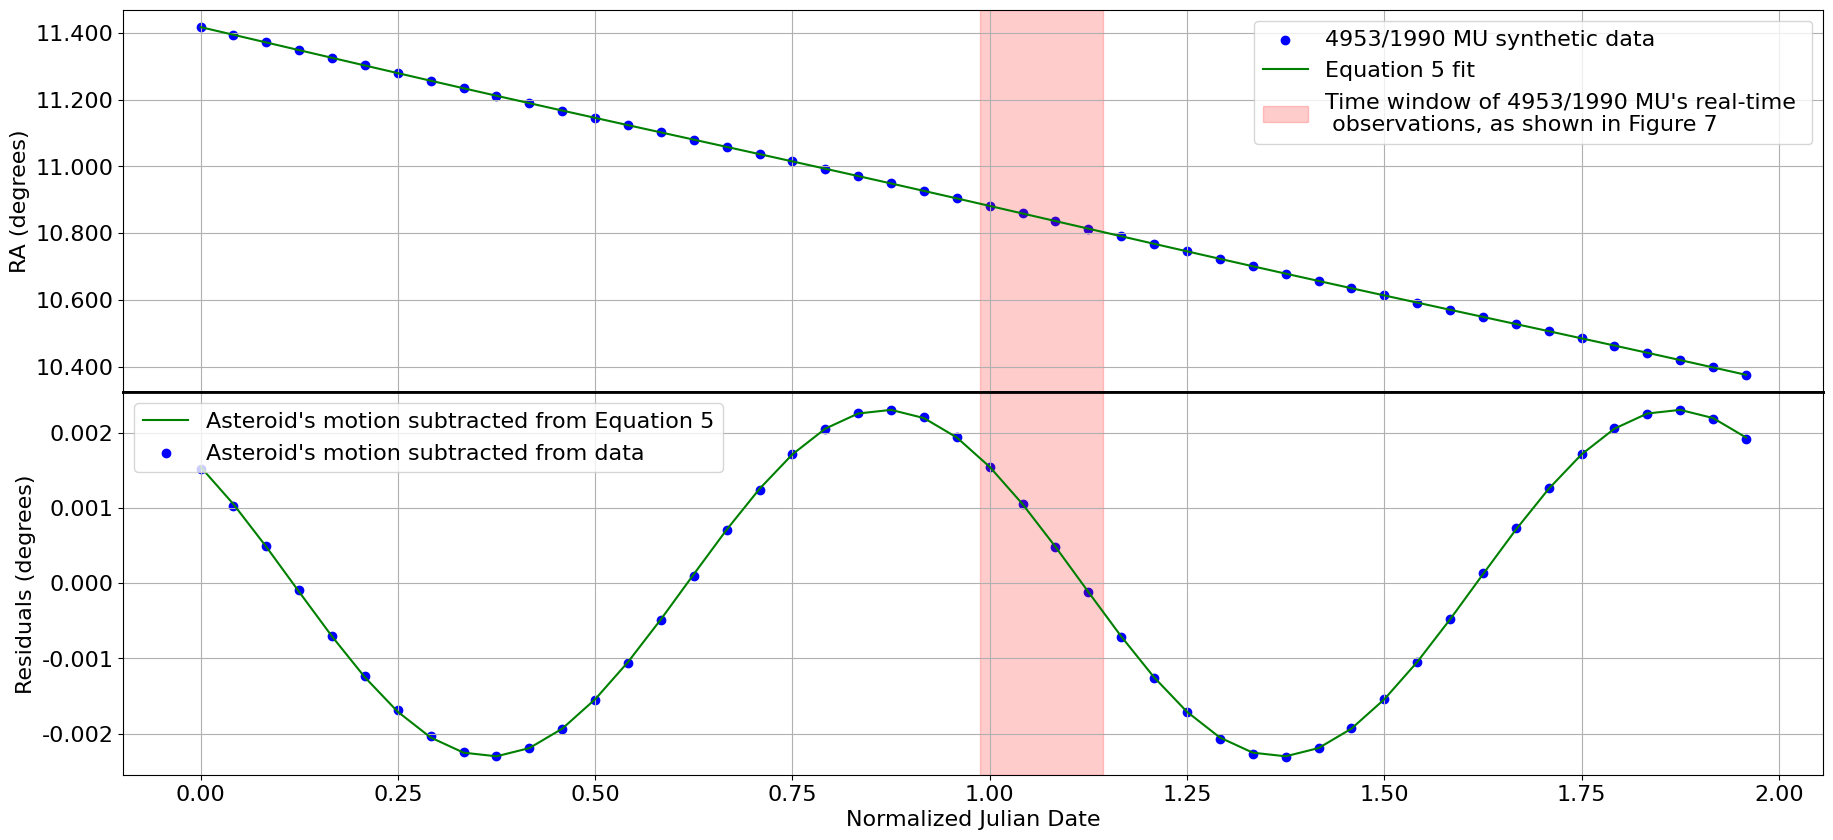

In [38]:
radians_to_degrees = 180 / np.pi

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 1, height_ratios=[1.5, 1.5, 1], figure=fig)

# Subplot 1: 
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(jd_binned_median, ra_deg_adjusted_detected, color='blue', label = '4953/1990 MU synthetic data')
ax1.plot(jd_binned_median, fit_function_linear(jd_binned_median, *params_sine), color='green', label = 'Equation 5 fit')
ax1.axvspan(0.988, 1.144, color='red', alpha=0.2, label="Time window of 4953/1990 MU's real-time \n observations, as shown in Figure 7")
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylabel("RA (degrees)", fontsize=16)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.set_xticklabels([])
ax1.legend(fontsize=16)
ax1.grid()

# Subplot 2: 
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(jd_binned_median, 
         fit_function_linear(jd_binned_median, *params_sine) - (params_sine[2]*jd_binned_median + params_sine[3] + params_sine[4]*jd_binned_median**2), 
         color = 'green', label = 'Asteroid\'s motion subtracted from Equation 5')
ax2.scatter(jd_binned_median, ra_deg_adjusted_detected - (params_sine[2]*jd_binned_median + params_sine[3] + params_sine[4]*jd_binned_median**2), 
            color = 'blue', label = 'Asteroid\'s motion subtracted from data')
ax2.axvspan(0.988, 1.144, color='red', alpha=0.2)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_xlabel("Normalized Julian Date", fontsize=16)
ax2.set_ylabel("Residuals (degrees)", fontsize=16) 
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.legend(fontsize=16)
ax2.grid()

plt.subplots_adjust(hspace=0)
plt.gcf().axes[0].spines['bottom'].set_linewidth(2)
plt.gcf().axes[1].spines['top'].set_linewidth(2)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.1, hspace=0)
plt.savefig("Figure 2.png", format="png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

# =============================================================================
# FINAL SUMMARY: Topocentric Parallax distance measurement for Asteroid 4953/1990 MU
# =============================================================================

In [39]:
# 1. Fit parameters from Equation 5
print("=== Fit Parameters from Equation 5 ===")
parameter_names = ["Am (deg)", "B", "C", "D", "E"]
for name, value, error in zip(parameter_names, params_sine, sine_uncertainties):
    print(f"{name:<10}: {value:.6e} ± {error:.6e}")

# 2. Parallax amplitude in radians
print("\n=== Parallax Amplitude ===")
print(f"Am (rad): {amplitude_rad:.6e} ± {amplitude_uncertainty_rad:.6e}")

# 3. Distance results
print("\n=== Distance to Asteroid 4953/1990 MU ===")
print(f"Distance:    {abs(asteroid_km):.2f} km   ({abs(asteroid_dist_au):.6f} au)")
print(f"Uncertainty: ± {abs(asteroid_uncertainty_km):.2f} km   (± {abs(asteroid_dist_uncertainty_au):.6f} au)")

# 4. Percentage Difference
print("\n=== Difference comparism with Horizons mean distance ===")
print(f"Percentage: {abs(percentage_difference):.2f} %")


# 4. Summary Text
summary_text = """ 
Summary:
--------
We input data of asteroid 4953/1990 MU from NASA JPL Horizons System from October 30-31, 2024, 
separated by 1 hour, totaling 48 observations. We add synthetic Gaussian noise of σ = 20 mas 
to the RA and DEC of the original data, to mimic realistic astrometric scatter, since 
Horizons does not provide measurement uncertainties. We then fit Equation 5 in the manuscript, 
which connects the Earth's rotation with the non-linear motion of the asteroid to 
the RA time series over the two days. 

The best-fit sinusoidal amplitude (Am) and its 1σ uncertainty were converted 
to radians and used in Equations 3 and 4 of the manuscript to compute the 
distance to asteroid 4953/1990 MU. The resulting distance and error bar are consistent 
with expectations for an object at this geometry and validate that the topocentric parallax 
method is implemented correctly. This confirms that the entire analysis pipeline: 
noise generation → model fitting → amplitude extraction → distance calculation, 
is functioning as described in the manuscript.
"""
print("\n" + summary_text)


=== Fit Parameters from Equation 5 ===
Am (deg)  : 2.305653e-03 ± 2.654001e-06
B         : 2.407312e+00 ± 1.160884e-03
C         : -5.398288e-01 ± 1.251500e-05
D         : 1.141590e+01 ± 5.363960e-06
E         : 3.755207e-03 ± 6.157297e-06

=== Parallax Amplitude ===
Am (rad): 4.024124e-05 ± 4.632106e-08

=== Distance to Asteroid 4953/1990 MU ===
Distance:    170955472.95 km   (1.142767 au)
Uncertainty: ± 196784.17 km   (± 0.001315 au)

=== Difference comparism with Horizons mean distance ===
Percentage: 0.36 %

 
Summary:
--------
We input data of asteroid 4953/1990 MU from NASA JPL Horizons System from October 30-31, 2024, 
separated by 1 hour, totaling 48 observations. We add synthetic Gaussian noise of σ = 20 mas 
to the RA and DEC of the original data, to mimic realistic astrometric scatter, since 
Horizons does not provide measurement uncertainties. We then fit Equation 5 in the manuscript, 
which connects the Earth's rotation with the non-linear motion of the asteroid to 
the RA